In [27]:
#standard libraries
import pandas as pd, numpy as np
import datetime

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

#from mpl_toolkits.mplot3d import Axes3D
#plt.rcParams["patch.force_edgecolor"] = True

from IPython.display import display, HTML


#store results
#from collections import OrderedDict


#warnings
import warnings 
warnings.filterwarnings("ignore")

#data transformation
from sklearn import preprocessing

#clusterization
from sklearn import cluster
from sklearn import mixture
from sklearn import decomposition
from sklearn import manifold

#classification
from sklearn import linear_model
from sklearn import ensemble

#quality control
from sklearn import metrics

#model learning on train / test
from sklearn import model_selection

import optuna
from optuna import Trial, study, samplers

In [18]:
new_data = pd.read_csv(r'C:\Users\Viktoriya.Ilicheva\Downloads\PROJECT-06\data\transformed.csv')
new_data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34


In [19]:
recency_data = new_data.groupby('CustomerID')['InvoiceDate'].max().reset_index()

In [20]:
recency_data['InvoiceDate'] = pd.to_datetime(recency_data['InvoiceDate'])
recency_data['Recency'] = pd.to_datetime('2011-12-10') - recency_data['InvoiceDate']
recency_data['Recency'] = recency_data['Recency'].dt.days

In [22]:
rfm_table = pd.DataFrame({
    'Recency': recency_data['Recency'].values,
    'Frequency': new_data.groupby('CustomerID')['InvoiceNo'].nunique(),
    'Monetary': new_data.groupby('CustomerID')['TotalPrice'].sum()
})

In [23]:
#set the limits for frequency and monetary
freq_bound = np.quantile(rfm_table['Frequency'], 0.95)
monetary_bound = np.quantile(rfm_table['Monetary'], 0.95)

#set the limits
rfm_table = rfm_table[~((rfm_table['Frequency'] > freq_bound) | (rfm_table['Monetary'] > monetary_bound))]
rfm_table.shape

(4035, 3)

In [24]:
#initialize the scaler
s_scaler = preprocessing.StandardScaler()

#standardize the data
rfm_table_scaled = s_scaler.fit_transform(rfm_table)

In [26]:
from sklearn.pipeline import Pipeline

pipeline_tsne = Pipeline([
    ('scaler', preprocessing.StandardScaler()), 
    ('tsne', manifold.TSNE(perplexity=50,
                           random_state=100))
])

tsne_data = pipeline_tsne.fit_transform(rfm_table)
print(f'Kullback–Leibler Divergence: {pipeline_tsne['tsne'].kl_divergence_:.3f}')

Kullback–Leibler Divergence: 0.539


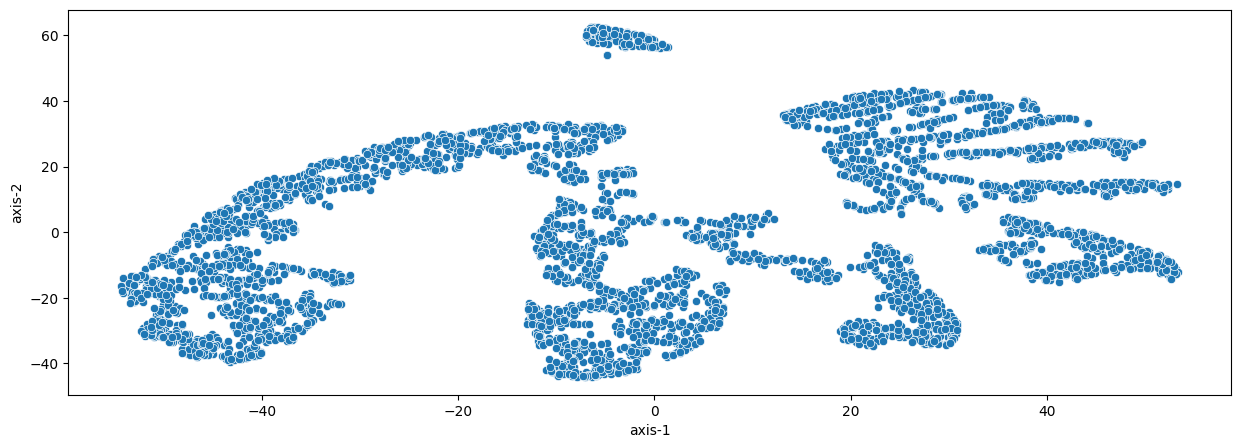

In [30]:
rfm_table_processed = pd.DataFrame(tsne_data,
                                   columns=['axis-1', 'axis-2'])

fig = plt.figure(figsize=(15, 5))
sns.scatterplot(data=rfm_table_processed,
                x='axis-1', y='axis-2');

In [31]:
def optuna_tsne(trial):
  #set hyperparameters
  #n_components = trial.suggest_categorical('n_components', [2])
  perplexity = trial.suggest_categorical('perplexity', [5, 10, 20, 30, 40, 50])
  init = trial.suggest_categorical('init', ['random', 'pca'])
  learning_rate = trial.suggest_categorical('learning_rate', [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600])
  early_exaggeration = trial.suggest_categorical('early_exaggeration', [1, 2, 3, 4, 5, 6, 7, 8])
  
  #use the combinations for model build
  model = manifold.TSNE(#n_components=n_components,
                        perplexity=perplexity,
                        learning_rate=learning_rate,
                        init=init,
                        early_exaggeration=early_exaggeration)
  
  tsne_results = model.fit(rfm_table_scaled)

  return round(tsne_results.kl_divergence_, 5)

In [32]:
%%time

#begin hyperparameters selection
#create review object
study_optuna = optuna.create_study(study_name='t-distributed stochastic neighbor embedding',
                                   direction='minimize')

#search for the best combination
study_optuna.optimize(optuna_tsne,
                      n_trials=10)

[I 2025-01-16 17:14:38,573] A new study created in memory with name: t-distributed stochastic neighbor embedding
[I 2025-01-16 17:14:49,156] Trial 0 finished with value: 0.70439 and parameters: {'perplexity': 5, 'init': 'pca', 'learning_rate': 600, 'early_exaggeration': 5}. Best is trial 0 with value: 0.70439.
[I 2025-01-16 17:15:01,025] Trial 1 finished with value: 0.99625 and parameters: {'perplexity': 5, 'init': 'random', 'learning_rate': 250, 'early_exaggeration': 1}. Best is trial 0 with value: 0.70439.
[I 2025-01-16 17:15:13,096] Trial 2 finished with value: 0.77851 and parameters: {'perplexity': 5, 'init': 'random', 'learning_rate': 150, 'early_exaggeration': 4}. Best is trial 0 with value: 0.70439.
[I 2025-01-16 17:15:27,581] Trial 3 finished with value: 0.64187 and parameters: {'perplexity': 10, 'init': 'pca', 'learning_rate': 500, 'early_exaggeration': 1}. Best is trial 3 with value: 0.64187.
[I 2025-01-16 17:15:44,798] Trial 4 finished with value: 0.56979 and parameters: {'p

CPU times: total: 3min 30s
Wall time: 2min 25s


In [33]:
print(f'best value: {study_optuna.best_value:.3f}')
print(f'best hyperparameters for t-sne: {study_optuna.best_params}')

best value: 0.537
best hyperparameters for t-sne: {'perplexity': 50, 'init': 'random', 'learning_rate': 200, 'early_exaggeration': 4}


In [36]:
#find the metrics for test data
model_opt_tsne = manifold.TSNE(**study_optuna.best_params,
                               random_state=100)

#model learning
tsne = model_opt_tsne.fit_transform(rfm_table_scaled)

#make a prediction
model_opt_tsne.kl_divergence_

0.5771048069000244

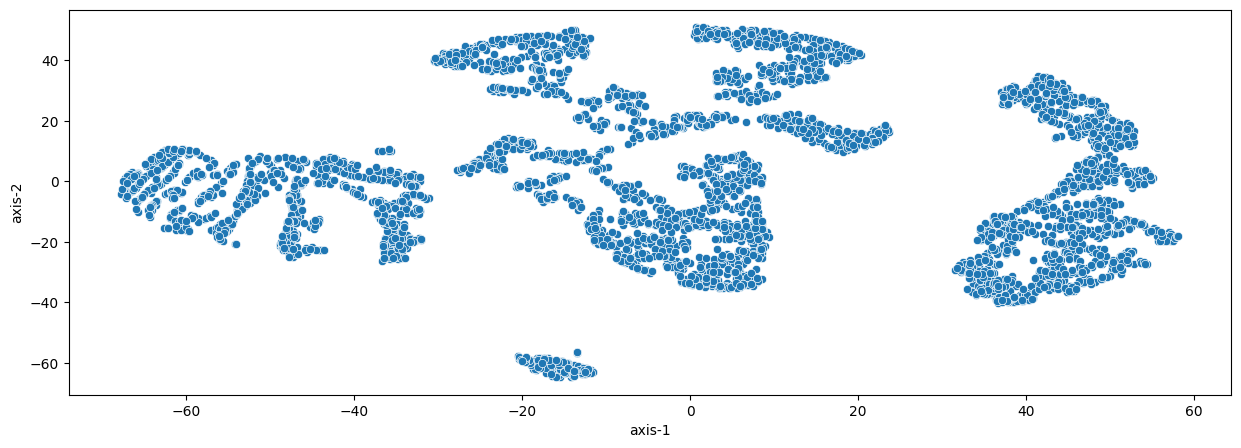

In [37]:
#create the dataframe to store the results
rfm_table_with_tsne = pd.DataFrame(tsne,
                                   columns=['axis-1', 'axis-2'])

#create the scatterplot to visualize the clusters
fig = plt.figure(figsize=(15, 5))
sns.scatterplot(data=rfm_table_with_tsne,
                x='axis-1', y='axis-2');

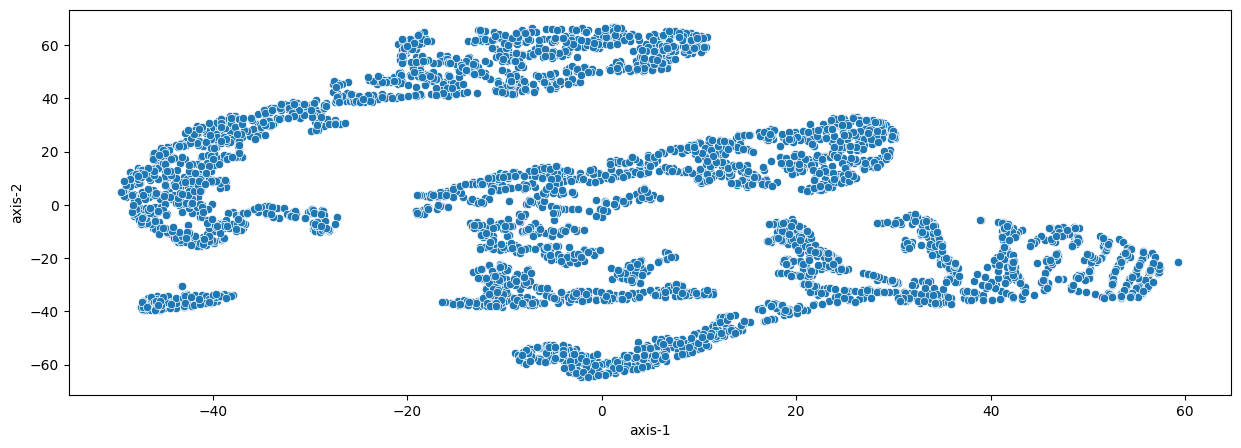

In [39]:
#find the metrics for test data
model_opt_tsne = manifold.TSNE(**study_optuna.best_params,
                               random_state=42)

#model learning
tsne = model_opt_tsne.fit_transform(rfm_table_scaled)

#make a prediction
model_opt_tsne.kl_divergence_

#create the dataframe to store the results
rfm_table_with_tsne = pd.DataFrame(tsne,
                                   columns=['axis-1', 'axis-2'])

#create the scatterplot to visualize the clusters
fig = plt.figure(figsize=(15, 5))
sns.scatterplot(data=rfm_table_with_tsne,
                x='axis-1', y='axis-2');